In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from datasets import load_dataset
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap



/home/hice1/dlee906/.conda/envs/my_ml_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
dataset["primary_diagnosis"]

NameError: name 'dataset' is not defined

In [ ]:
from datasets import load_dataset
import os
from torch.utils.data import Dataset
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, hf_dataset):
        self.hf_dataset = hf_dataset

    def __len__(self):
        return len(self.hf_dataset)
    
    def __getitem__(self, idx):
        hf_item = self.hf_dataset[idx]
        embedding = np.frombuffer(hf_item["embedding"], dtype=np.float32)
        embedding_shape = hf_item["embedding_shape"]
        embedding = embedding.reshape(embedding_shape)
        return embedding

if __name__ == "__main__":
    
    clinical_dataset = load_dataset("Lab-Rasool/TCGA", "clinical", split="gatortron")
    wsi_dataset = load_dataset("Lab-Rasool/TCGA", "wsi", split="uni")
    
    for index, item in enumerate(clinical_dataset):
        print(np.frombuffer(item.get("embedding"), dtype=np.float32).reshape(item.get("embedding_shape")).shape)
        break


Generating gatortron split: 11428 examples [00:00, 63469.11 examples/s]
Generating biobert split: 11428 examples [00:00, 82725.69 examples/s]
Generating uni split: 22643 examples [00:05, 4017.07 examples/s]

(1, 1, 1024)


In [7]:
dataset = load_dataset("Lab-Rasool/TCGA", "clinical", split="gatortron")

dataset.column_names

['project_id',
 'case_id',
 'case_submitter_id',
 'selected_normal_wgs',
 'source_center',
 'state',
 'a260_a280_ratio',
 'normal_tumor_genotype_snp_match',
 'ribosomal_rna_28s_16s_ratio',
 'rna_integrity_number',
 'age_at_index',
 'days_to_birth',
 'days_to_death',
 'ethnicity',
 'gender',
 'race',
 'vital_status',
 'year_of_birth',
 'year_of_death',
 'age_at_diagnosis',
 'ajcc_clinical_m',
 'ajcc_pathologic_n',
 'ajcc_pathologic_stage',
 'ajcc_pathologic_t',
 'classification_of_tumor',
 'days_to_diagnosis',
 'icd_10_code',
 'last_known_disease_status',
 'morphology',
 'primary_diagnosis',
 'prior_malignancy',
 'prior_treatment',
 'progression_or_recurrence',
 'site_of_resection_or_biopsy',
 'synchronous_malignancy',
 'tissue_or_organ_of_origin',
 'tumor_grade',
 'year_of_diagnosis',
 'treatment_or_therapy',
 'alcohol_history',
 'is_ffpe',
 'composition',
 'days_to_collection',
 'days_to_sample_procurement',
 'initial_weight',
 'pathology_report_uuid',
 'portion_submitter_id',
 'perce

In [14]:
embeddings = np.array(dataset['embedding'])  # (11208, embedding_dim)

# Optional: check shape
print(embeddings.shape)

(11428,)


In [ ]:
dataset["primary_diagnosis"]

Original Embeddings shape: (11428,)


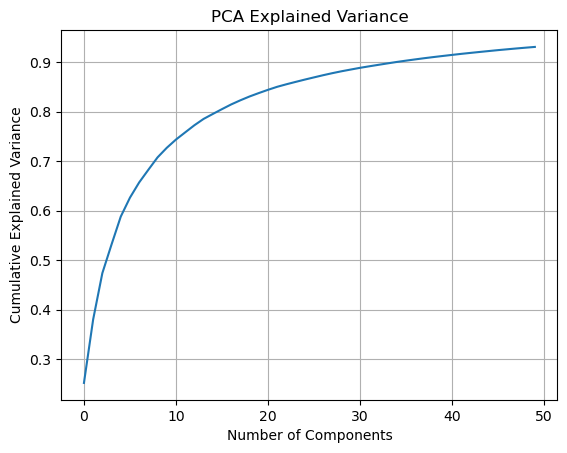

/home/hice1/dlee906/.conda/envs/my_ml_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/hice1/dlee906/.conda/envs/my_ml_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


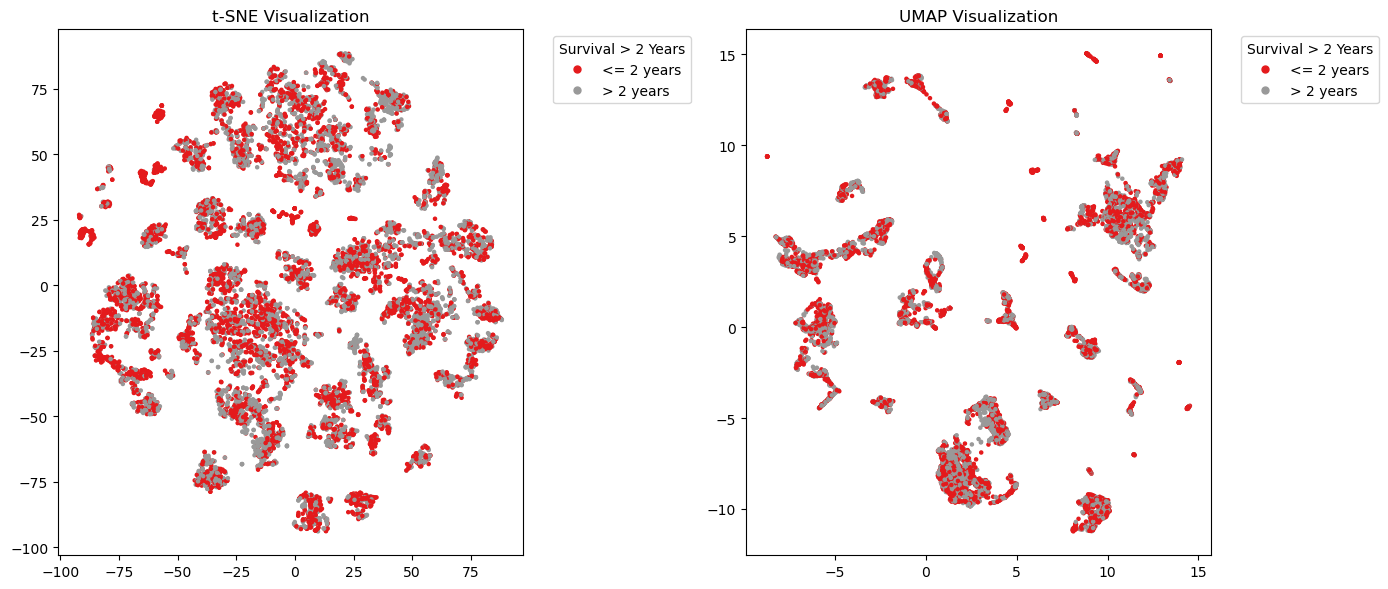

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from datasets import load_dataset

# Load dataset
dataset = load_dataset("Lab-Rasool/TCGA", "clinical", split="gatortron")

# Step 1: Extract embeddings
embeddings = np.array(dataset['embedding'])  # Shape: (11208, embedding_dim)
print('Original Embeddings shape:', embeddings.shape)

# Handle byte-encoded embeddings
if isinstance(embeddings[0], (bytes, np.bytes_)):
    embeddings = np.array([np.frombuffer(x, dtype=np.float32) for x in embeddings])

# Handle NaNs if any
if np.isnan(embeddings).any():
    print("NaNs found in embeddings. Imputing...")
    imputer = SimpleImputer(strategy='mean')
    embeddings = imputer.fit_transform(embeddings)

# Normalize embeddings
scaler = StandardScaler()
embeddings = scaler.fit_transform(embeddings)

# Step 2: PCA reduction
pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(embeddings)

# Plot explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.title('PCA Explained Variance')
plt.show()

# Step 3: t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_tsne = tsne.fit_transform(embeddings_pca)

# Step 4: UMAP
reducer = umap.UMAP(random_state=42)
embeddings_umap = reducer.fit_transform(embeddings_pca)

# Step 5: Label extraction
labels = np.array(dataset['days_to_death'], dtype=np.float32)
follow_up = np.array(dataset['days_to_last_follow_up'], dtype=np.float32)

# Use follow-up time for censored patients
effective_days = np.where(np.isnan(labels), follow_up, labels)

# Binary labels: 0 = <= 2 years, 1 = > 2 years
binary_labels = (effective_days > 730).astype(int)
labels_encoded = binary_labels  # Already in binary form
class_names = ['<= 2 years', '> 2 years']

# Step 6: Plotting
plt.figure(figsize=(14, 6))

# t-SNE plot
plt.subplot(1, 2, 1)
scatter_tsne = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels_encoded, cmap='Set1', s=5)
plt.title('t-SNE Visualization')
colors = plt.cm.Set1(np.linspace(0, 1, len(class_names)))
handles = [plt.Line2D([], [], marker='o', color=colors[idx], linestyle='', markersize=5, label=class_name)
           for idx, class_name in enumerate(class_names)]
plt.legend(handles=handles, title='Survival > 2 Years', bbox_to_anchor=(1.05, 1), loc='upper left')

# UMAP plot
plt.subplot(1, 2, 2)
scatter_umap = plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], c=labels_encoded, cmap='Set1', s=5)
plt.title('UMAP Visualization')
handles = [plt.Line2D([], [], marker='o', color=colors[idx], linestyle='', markersize=5, label=class_name)
           for idx, class_name in enumerate(class_names)]
plt.legend(handles=handles, title='Survival > 2 Years', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiTaskCancerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, use_survival_analysis=False):
        super(MultiTaskCancerModel, self).__init__()
        self.use_survival_analysis = use_survival_analysis
        
        # Shared encoder
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Recurrence classification head (binary)
        self.recurrence_classifier = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Output logits
        )
        
        if use_survival_analysis:
            # Cox-PH survival head (log-risk output)
            self.survival_head = nn.Linear(hidden_dim, 1)
        else:
            # MSE regression head for survival days
            self.survival_regressor = nn.Sequential(
                nn.Linear(hidden_dim, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )

    def forward(self, x):
        shared_out = self.shared(x)
        
        recurrence_logits = self.recurrence_classifier(shared_out).squeeze(1)  # [B]
        
        if self.use_survival_analysis:
            survival_risk = self.survival_head(shared_out).squeeze(1)  # [B]
            return recurrence_logits, survival_risk
        else:
            survival_days = self.survival_regressor(shared_out).squeeze(1)  # [B]
            return recurrence_logits, survival_days


In [11]:
def cox_ph_loss(risk, durations, events):
    """Computes Cox partial likelihood loss."""
    order = torch.argsort(durations, descending=True)
    risk = risk[order]
    events = events[order]

    log_cumsum = torch.logcumsumexp(risk, dim=0)
    loss = -torch.sum((risk - log_cumsum) * events)
    return loss


In [12]:
model = MultiTaskCancerModel(input_dim=combined_feature_dim, use_survival_analysis=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

recurrence_logits, survival_output = model(x)

loss_recur = nn.BCEWithLogitsLoss()(recurrence_logits, recurrence_labels.float())
loss_surv = cox_ph_loss(survival_output, durations, events)  # or MSE if regression
total_loss = loss_recur + loss_surv

total_loss.backward()
optimizer.step()


NameError: name 'combined_feature_dim' is not defined

In [51]:
from datasets import load_dataset
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import torch.nn as nn
import torch.optim as optim


In [52]:
class ClinicalSurvivalDataset(Dataset):
    def __init__(self, hf_dataset, survival_days=730):
        self.samples = []
        for item in hf_dataset:
            if item["days_to_death"] is not None:
                embedding = np.frombuffer(item["embedding"], dtype=np.float32)
                embedding = embedding.reshape(item["embedding_shape"])
                label = 1 if int(item["days_to_death"]) >= survival_days else 0
                self.samples.append((embedding, label))

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        embedding, label = self.samples[idx]
        return torch.tensor(embedding, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

In [53]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [54]:
clinical_dataset = load_dataset("Lab-Rasool/TCGA", "clinical", split="gatortron")
dataset = ClinicalSurvivalDataset(clinical_dataset)

# Split into train and val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [55]:
sample_input, _ = next(iter(train_loader))
input_dim =  sample_input.view(sample_input.size(0), -1).shape[1] 

model = MLP(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [58]:
def train(model, loader):
    model.train()
    total_loss = 0
    for x, y in loader:
        optimizer.zero_grad()
        # print(x.shape)
        # print(y.shape)
        output = model(x).squeeze()
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    total_correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            preds = model(x).squeeze() > 0.5
            total_correct += (preds == y.bool()).sum().item()
            total += y.size(0)
    return total_correct / total

In [60]:
for epoch in range(50):
    train_loss = train(model, train_loader)
    val_acc = evaluate(model, val_loader)
    print(f"Epoch {epoch+1} - Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1 - Loss: 0.6400, Val Acc: 0.6408
Epoch 2 - Loss: 0.6390, Val Acc: 0.6172
Epoch 3 - Loss: 0.6339, Val Acc: 0.6117
Epoch 4 - Loss: 0.6399, Val Acc: 0.6380
Epoch 5 - Loss: 0.6331, Val Acc: 0.6657
Epoch 6 - Loss: 0.6350, Val Acc: 0.6519
Epoch 7 - Loss: 0.6401, Val Acc: 0.6616
Epoch 8 - Loss: 0.6366, Val Acc: 0.6657
Epoch 9 - Loss: 0.6397, Val Acc: 0.6796
Epoch 10 - Loss: 0.6329, Val Acc: 0.6602
Epoch 11 - Loss: 0.6338, Val Acc: 0.6533
Epoch 12 - Loss: 0.6289, Val Acc: 0.6782
Epoch 13 - Loss: 0.6340, Val Acc: 0.6436
Epoch 14 - Loss: 0.6394, Val Acc: 0.6103
Epoch 15 - Loss: 0.6278, Val Acc: 0.6422
Epoch 16 - Loss: 0.6394, Val Acc: 0.6630
Epoch 17 - Loss: 0.6274, Val Acc: 0.6283
Epoch 18 - Loss: 0.6280, Val Acc: 0.6144
Epoch 19 - Loss: 0.6320, Val Acc: 0.5992
Epoch 20 - Loss: 0.6252, Val Acc: 0.7004
Epoch 21 - Loss: 0.6292, Val Acc: 0.6907
Epoch 22 - Loss: 0.6213, Val Acc: 0.6519
Epoch 23 - Loss: 0.6342, Val Acc: 0.6671
Epoch 24 - Loss: 0.6158, Val Acc: 0.6505
Epoch 25 - Loss: 0.6186, 